# Homework 1: Simulation-Based Data Analysis

BEE 4850/5850, Fall 2024

**Name**:

**ID**:

> **Due Date**
>
> Friday, 2/2/24, 9:00pm

## Overview

### Instructions

The goal of this homework assignment is to introduce you to
simulation-based data analysis.

-   Problem 1 asks you to explore whether a difference between data
    collected from two groups might be statistically meaningful or the
    result of noise. This problem repeats the analysis from [Statistics
    Without The Agonizing
    Pain](https://www.youtube.com/watch?v=5Dnw46eC-0o) by John Rauser
    (which is a neat watch!).
-   Problem 2 asks you to evaluate an interview method for finding the
    level of cheating on a test to determine whether cheating was
    relatively high or low. This problem was adapted from [Bayesian
    Methods for
    Hackers](https://dataorigami.net/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).
-   Problem 3 asks you to assess the quality of fit of a normal
    distribution to realizations from a Galton Board simulation.
-   Problem 4 (**graded only for graduate students**) asks you to
    simulate outcomes from the *Price Is Right* Showcase game to
    identify a bidding strategy.

### Learning Outcomes

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

The following packages are included in the environment (to help you find
other similar packages in other languages). The code below loads these
packages for use in the subsequent notebook (the desired functionality
for each package is commented next to the package).

In [2]:
using Random # random number generation and seed-setting
using DataFrames # tabular data structure
using CSVFiles # reads/writes .csv files
using Distributions # interface to work with probability distributions
using Plots # plotting library
using StatsBase # statistical quantities like mean, median, etc
using StatsPlots # some additional statistical plotting tools

## Problems (Total: 20 Points)

### Problem 1 (10 points)

The underlying question we would like to address is: what is the
influence of drinking beer on the likelihood of being bitten by
mosquitoes? There is a mechanistic reason why this might occur:
mosquitoes are attracted by changes in body temperature and released
CO<sub>2</sub>, and it might be that drinking beer induces these
changes. We’ll analyze this question using (synthetic) data which
separates an experimental population into two groups, one which drank
beer and the other which drank only water.

First, we’ll load data for the number of bites reported by the
participants who drank beer. This is in a comma-delimited file,
`data/bites.csv` (which is grossly overkill for this assignment). Each
row contains two columns: the group (`beer` and `water`) the person
belonged to and the number of times that person was bitten.

In Julia, we can do this using
[`CSVFiles.jl`](https://github.com/queryverse/CSVFiles.jl), which will
read in the `.csv` file into a
[`DataFrame`](https://dataframes.juliadata.org/stable/), which is a
typical data structure for tabular data (and equivalent to a Pandas
`DataFrame` in Python or a `dataframe` in R).

In [3]:
data = DataFrame(load("data/bites.csv")) # load data into DataFrame

# print data variable (semi-colon suppresses echoed output in Julia, which in this case would duplicate the output)
@show data; 

How can we tell if there’s a meaningful difference between the two
groups? Naively, we might just look at the differences in group means.

> **Broadcasting**
>
> The subsetting operations in the below code use `.==`, which
> “broadcasts” the element-wise comparison operator == across every
> element. The decimal in front of `==` indicates that this should be
> used element-wise (every pair of elements compared for equality,
> returning a vector of `true` or `false` values); otherwise Julia would
> try to just check for vector equality (returning a single `true` or
> `false` value).
>
> Broadcasting is a very specific feature of Julia, so this syntax would
> look different in a different programming language.

In [4]:
# split data into vectors of bites for each group
beer = data[data.group .== "beer", :bites]
water = data[data.group .== "water", :bites]

observed_difference = mean(beer) - mean(water)
@show observed_difference;

observed_difference = 4.37777777777778

This tells us that, on average, the participants in the experiment who
drank beer were bitten approximately 4.4 more times than the
participants who drank water! Does that seem like a meaningful
difference, or could it be the result of random chance?

We will use a *simulation* approach to address this question, as
follows.

-   Suppose someone is skeptical of the idea that drinking beer could
    result in a higher attraction to mosquitoes, and therefore more
    bites. To this skeptic, the two datasets are really just different
    samples from the same underlying population of people getting bitten
    by mosquitoes, rather than two different populations with different
    propensities for being bitten. This is the skeptic’s *hypothesis*,
    versus our hypothesis that drinking beer changes body temperature
    and CO<sub>2</sub> release sufficiently to attract mosquitoes.
-   If the skeptic’s hypothesis is true, then we can “shuffle” all of
    the measurements between the two datasets and re-compute the
    differences in the means. After repeating this procedure a large
    number of times, we would obtain a distribution of the differences
    in means under the assumption that the skeptic’s hypothesis is true.
-   Comparing our experimentally-observed difference to this
    distribution, we can then evaluate the consistency of the skeptic’s
    hypothesis with the experimental results.

> **Why Do We Call This A Simulation-Based Approach?**
>
> This is a simulation-based approach because the “shuffling” is a
> non-parametric way of generating new samples from the underlying
> distribution (more on this later in the semester).
>
> The alternative to this approach is to use a statistical test, such as
> a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), which
> [may have other
> assumptions](https://en.wikipedia.org/wiki/Student%27s_t-test#Assumptions)
> which may not be appropriate for this setting, particularly given the
> seemingly small sample sizes.

**In this problem**:

-   Conduct the above procedure to generate 50,000 simulated datasets
    under the skeptic’s hypothesis.
-   Plot a histogram of the results and add a dashed vertical line to
    show the experimental difference (if you are using Julia, feel free
    to look at the [Making Plots with Julia
    tutorial](https://viveks.me/simulation-data-analysis/tutorials/julia-plots.html)
    on the class website).
-   Draw conclusions about the plausibility of the skeptic’s hypothesis
    that there is no difference between groups. Feel free to use any
    quantitative or qualitative assessments of your simulations and the
    observed difference.

### Problem 2 (10 points)

You are trying to detect if how prevalent cheating was on an exam. You
are skeptical of the efficacy of just asking the students if they
cheated. You are also concerned about privacy — your goal is not to
punish individual students, but to see if there are systemic problems
that need to be addressed. Someone proposes the following interview
procedure, which the class agrees to participate in:

> Each student flips a fair coin, with the results hidden from the
> interviewer. The student answers honestly if the coin comes up heads.
> Otherwise, if the coin comes up tails, the student flips the coin
> again, and answers “I did cheat” if heads, and “I did not cheat”, if
> tails.

We have a hypothesis that cheating was not prevalent, and the proportion
of cheaters was no more than 5% of the class; in other words, we expect
5 “true” cheaters out of a class of 100 students. Our TA is more jaded
and thinks that cheating was more rampant, and that 30% of the class
cheated. The proposed interview procedure is noisy: the interviewer does
not know if an admission means that the student cheated, or the result
of a heads. However, it gives us a data-generating process that we can
model and analyze for consistency with our hypothesis and that of the
TA.

**In this problem**:

-   Derive and code a simulation model for the above interview procedure
    given the “true” probability of cheating $p$.
-   Simulate your model (for a class of 100 students) 50,000 times under
    the your hypothesis and the TA’s hypothesis, and plot the two
    resulting datasets.
-   If you received 31 “Yes, I cheated” responses while interviewing
    your class, what could you conclude? Feel free to use any
    qualitative or quantiative assessments to justify your conclusions.
-   How useful do you think the interview procedure is to identify
    systemic teaching? What changes to the design might you make?

### Problem 3 (10 points)

Suppose that we ask a class of students to walk individually from one
end of a field to the other and count the number of steps that they take
in order to cover the distance. More than likely, each student will get
a somewhat different answer. After each student has paced off the field,
we then make a histogram of the number of steps taken by the individual
students. For a sufficiently large number of students, this histogram
would resemble a normal distribution, due to the [Central Limit
Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

A **Galton board** (named after [Sir Francis
Galton](https://en.wikipedia.org/wiki/Francis_Galton), a pioneering
statistician[1], shown below, is a physical device that demonstrates the
Central Limit Theorem. A Galton board has rows of pins arranged in a
triangular shape, with each row of pins offset horizontally relative to
the rows above and below it. As illustrated in
<a href="#fig-galton" class="quarto-xref">Figure 1</a>, the top row has
one pin, the second row has two pins, and so forth. If you’ve watched
*The Price is Right*, you’ve seen this as
[“Plinko”](https://priceisright.fandom.com/wiki/Plinko).

[1] And, notably, a leading eugenicist, which is unfortunately a
recurring theme with leading early statisticians…)

<figure id="fig-galton">
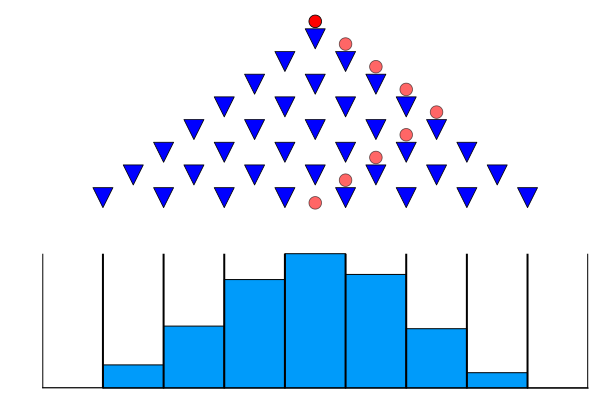
<figcaption>Figure 1: Galton Board simulation. The top shows a schematic
of how the Galton board works and the bottom shows a histogram of the
landing positions after 200 simulations.</figcaption>
</figure>

If a ball is dropped into the Galton board, it falls either to the right
or the left when it bounces off the top pin. The ball then falls all the
way to the bottom of the board, moving slightly to the right or left as
it passes through each row of pins. Bins at the bottom of the board
capture the ball and record its final position. If this experiment is
repeated with many balls, the number of balls in each bin resembles a
normal distribution, which is expected due to the Central Limit Theorem.

Your goal in this exercise is to explore how well a normal distribution
fits the outcomes of repeated Galton Board trials as the number
increases using quantile-quantile plots. Assessing the appropriateness
of a probability model for a data set is a key part of exploratory
analysis; we will return to this theme repeatedly. Or, to put it another
way, it’s time for you to play Plinko!

**In this problem**:

-   Write a function `galton_sim` which simulates `n` Galton board
    trials (assume the board has 8 board rows, as in the image above)
    and returns a vector with the number of balls which fall into each
    bin. You can assume (for now) that the board is fair, *e.g.* that
    the probability of a left or right bounce is 0.5; you may want to
    make this probability a function parameter so you can change it
    later.
-   Run your simulation for a sample of 50 balls. Create a histogram of
    the results, with each bar corresponding to one bin. Make sure you
    use a random seed for reproducibility, and label your axes!
-   Each Galton board trial can be represented as a realization from a
    [binomial
    distribution](https://en.wikipedia.org/wiki/Binomial_distribution).
    But as we noted above, by the Central Limit Theorem, the
    distribution of a large enough number of trials should be
    approximately normal. Use a [quantile-quantile (Q-Q)
    plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) to compare a
    fitted normal distribution with your simulation results. How well
    does a normal distribution fit the data?
-   Repeat your simulation experiment with 250 trials and compare to a
    normal distribution. Does it describe the empirical distribution
    better?
-   If the probability of a left bounce is 70%, what does this do to the
    fit of a normal distribution? What other distribution might you use
    if not a normal and why?

### Problem 4 (10 points)

<span style="color:red;">GRADED FOR 5850 STUDENTS ONLY</span>

Your mastery of the Central Limit Theorem has led you to win your game
of Plinko, and it’s time for the
[Showcases](https://priceisright.fandom.com/wiki/Showcases). This is the
final round of an episode of The Price is Right, matching the two big
winners from the episode. Each contestant is shown a “showcase” of
prizes, which are usually some combination of a trip, a motor vehicle,
some furniture, and maybe some other stuff. They then each have to make
a bid on the retail price of the showcase. The rules are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within $\$250$ of the retail price and is
    closer than their opponent, they win both showcases.

Thanks to [exhaustive statistics kept by game show
fans](http://tpirstats.com/Season51/Stats.htm), in Season 51 of *The
Price is Right* showcase values had the following properties:

-   median: \$33,0481;
-   lowest-value: \$20,432
-   highest-value: \$72,409

**In this problem**:

-   Write down a model which encodes the Showcase rules as a function of
    the showcase value and your bid. You can assume that your wagering
    is independent of your opponent.
-   Select and fit a distribution to the above statistics (you have some
    freedom to pick a distribution, but make sure you justify it).
-   Using 1,000 samples from your price distribution in your model, plot
    the expected winnings for bids from \$20,000 through \$72,000.
-   Find the bid which maximizes your expected winnings. If you were
    playing *The Price Is Right*, is this the strategy you would adopt,
    or are there other considerations you would take into account which
    were not included in this model?